In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/normalized_neural_activations_1/dataset.hdf5", 'r') as h5file: 
    decoder_metric_holder = []
    for i in tqdm(range(decoder_layers)):
        data_list = []
        labels_list = []
        for pass_name, pass_group in h5file.items():
            if pass_name.startswith('pass_'):
                label_level = []    
                for label_name, label_group in pass_group.items():
                    if label_name.startswith('label_') and 'decoder_latent' in label_group and label_name in alpha_labels:
                        label_level.append(label_group['decoder_latent'][i][0].copy())
                        labels_list.append(label_name)
                    
                
                data_list.extend(label_level)
        # Compute metric and append to holder
        regular = compute_metric(data_list, labels_list, dim=197)
        decoder_metric_holder.append(regular)

100%|██████████| 8/8 [00:38<00:00,  4.84s/it]


In [13]:
encoder_matrix = torch.vstack(encoder_metric_holder)
decoder_matrix = torch.vstack(decoder_metric_holder)
padding_width = decoder_matrix.shape[1] - encoder_matrix.shape[1]
padded_encoder_matrix = torch.nn.functional.pad(encoder_matrix, (0, padding_width))
stacked_matrix = torch.vstack([padded_encoder_matrix, decoder_matrix])

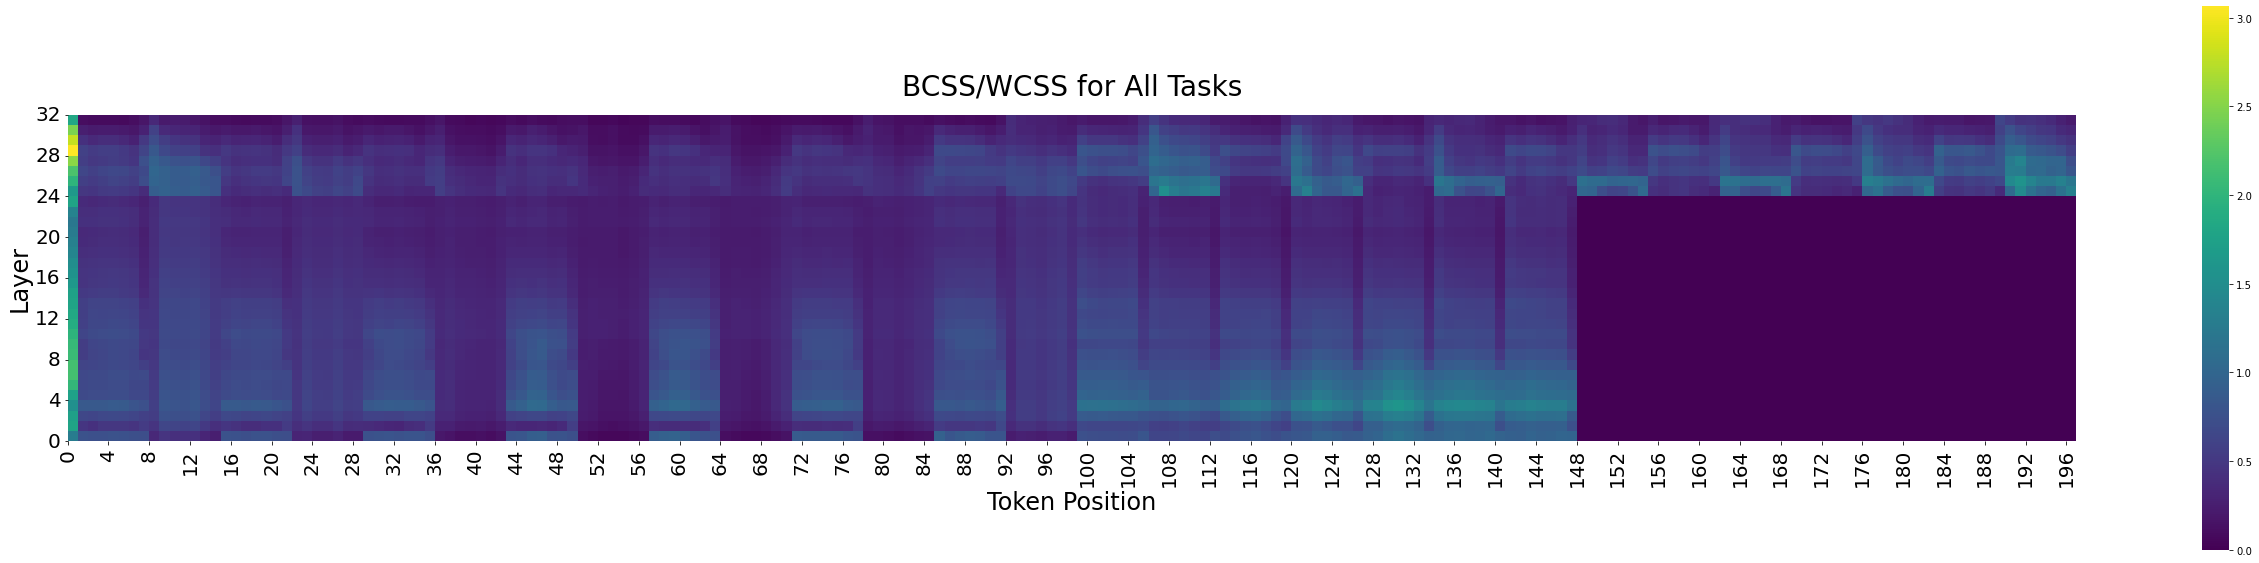

In [14]:
def plot_widemap(matrix_data, title):

    # Creating the heatmap
    plt.figure(figsize=(45, 10))  # Adjust the figure size as needed
    sns.heatmap(matrix_data, cmap='viridis', square=True)

    # Setting the labels for axes
    plt.xlabel('Token Position', fontsize=24)
    plt.ylabel('Layer', fontsize=24)

    # Inverting the y-axis to have the first layer at the bottom
    plt.gca().invert_yaxis()

    # Adding title
    plt.title(title, fontsize=28, pad=20)
    plt.yticks(np.arange(0, matrix_data.shape[0]+1, 4), np.arange(0, matrix_data.shape[0]+1, 4), fontsize=20)
    plt.xticks(np.arange(0, matrix_data.shape[1]+1, 4), np.arange(0, matrix_data.shape[1]+1, 4), fontsize=20)

    plt.show()

plot_widemap(stacked_matrix, 'BCSS/WCSS for All Tasks')
#plot_widemap(stacked_matrix_alpha, 'BCSS/WCSS for Constrained Tasks (alpha)')

In [46]:
import torch

def unpatchify_adapted(x):
    """
    x: (N, 196)
    imgs: (N, 14, 14)
    """
    h = w = 14  # Image dimensions
    imgs = x.reshape(x.shape[0], h, w)
    return imgs

def create_special_image(pixels):
    # Initialize an empty 14x14 array
    image = torch.zeros(14, 14)

    # Fill the top half (7 rows) with the first 98 pixels
    top_half = torch.tensor(pixels[:98]).reshape(7, 14)
    image[:7, :] = top_half

    # Fill the bottom-left quadrant with the next 49 pixels
    bottom_left_quadrant = torch.tensor(pixels[98:]).reshape(7, 7)
    image[7:, :7] = bottom_left_quadrant

    return image

def batch_process(stacked_matrix, decoder_only=False):
    # Split the matrix into two parts
    if decoder_only:
        full_images = stacked_matrix
        combined = unpatchify_adapted(full_images)
    else:
        special_images = stacked_matrix[:24, :147]  # First 24 images, first 147 pixels
        full_images = stacked_matrix[24:,]       # Last 8 images, excluding the first pixel



    # Process the special images
        special_processed = torch.stack([create_special_image(img) for img in special_images])

    # Process the full images
        full_processed = unpatchify_adapted(full_images)

    # Combine the results
        combined = torch.cat((special_processed, full_processed), dim=0)
    return combined


In [63]:
stacked_matrix = avg_tensor


In [64]:
batched_images = batch_process(stacked_matrix[:, 1:], decoder_only=True)

/tmp/ipykernel_589876/1701896249.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to account for the added colorbar axis


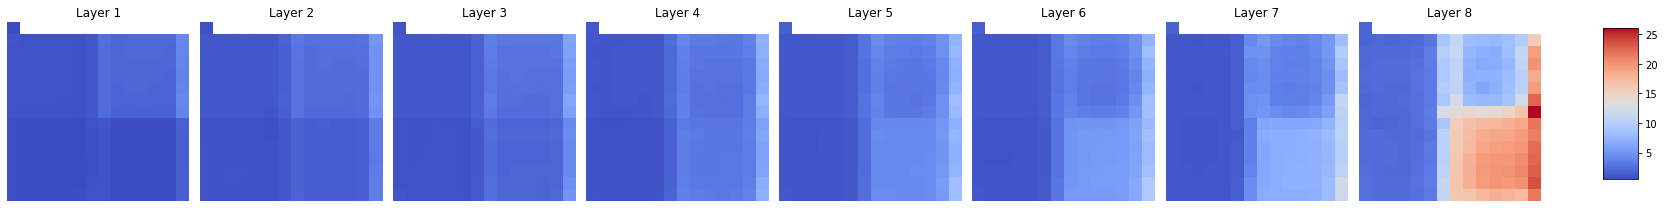

In [71]:
# Find global min and max for consistent color range across all heatmaps
global_min = stacked_matrix.min()
global_max = stacked_matrix.max()

batched_alpha_pixel = stacked_matrix[:, :1].squeeze()

# Set up the matplotlib figure with 32 subplots for images and 32 for alpha_pixel indicators
fig, axes = plt.subplots(batched_images.shape[0]//8, 8, figsize=(24, 12/(4/(batched_images.shape[0]//8))))  # Adjust the figure size as needed
fig.patch.set_facecolor('white')  # Set the background to white

# Generate heatmaps for each image with an additional alpha pixel
for i, ax in enumerate(axes.flatten()):
    # Create a 15x14 matrix with NaNs and place the alpha_pixel at the top left
    extended_matrix = np.full((15, 14), np.nan)
    extended_matrix[0, 0] = batched_alpha_pixel[i]  # Set the top left to the alpha_pixel value
    extended_matrix[1:, :] = batched_images[i]      # Place the original image below

    # Plot the extended heatmap
    sns.heatmap(extended_matrix, cmap='coolwarm', ax=ax, cbar=False, square=False,
                vmin=global_min, vmax=global_max, mask=np.isnan(extended_matrix))
    ax.set_title(f'Layer {i+1}')
    ax.set_xticks([])
    ax.set_yticks([])

# Create an axis for the color bar on the right side
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height
norm = plt.Normalize(global_min, global_max)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

# Add the main title

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect to account for the added colorbar axis
plt.show()

In [44]:
avg_tensor.shape


torch.Size([8, 197])

In [97]:
import os
import imageio

global_min = stacked_matrix.min().item()
global_max = stacked_matrix.max().item()

frames_dir = 'gif/frames'
os.makedirs(frames_dir, exist_ok=True)

# Filename for the gif
gif_filename = 'gif/heatmap_animation.gif'

# Generate and save each frame
filenames = []
for i in range(len(batched_images)):
    # Create a 15x14 matrix with NaNs and place the alpha_pixel at the top left
    extended_matrix = np.full((15, 14), np.nan)
    extended_matrix[0, 0] = batched_alpha_pixel[i].item()  # Set the top left to the alpha_pixel value
    extended_matrix[1:, :] = batched_images[i].numpy()     # Place the original image below

    # Plot the extended heatmap
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(extended_matrix, cmap='coolwarm', ax=ax, cbar=False, square=False,
                vmin=global_min, vmax=global_max, mask=np.isnan(extended_matrix))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Layer {i+1}')

    # Save the frame
    frame_filename = f'{frames_dir}/frame_{i:04d}.png'
    plt.savefig(frame_filename)
    plt.close()
    filenames.append(frame_filename)

# Compile the frames into a GIF
with imageio.get_writer(gif_filename, mode='I', duration=0.5, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# The path to the GIF file that has been created
gif_path = gif_filename

/tmp/ipykernel_2454058/1778093125.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


NameError: name 'shutil' is not defined

In [8]:
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/normalized_neural_activations_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    labels = list(first_element.keys())
    

In [9]:
labels

['label_colorization',
 'label_inpaint double random',
 'label_inpaint single random',
 'label_lowlight enhance',
 'label_segmentation',
 'label_uncolor']

In [15]:
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/baseline_ncollect/dataset.hdf5", 'r') as h5file: 
    avg_tensors = {}
    for i in tqdm(range(len(labels))):
        tensor_holder = []
        for pass_name, pass_group in h5file.items():
            tensor_holder.append(pass_group[labels[i]]['decoder_latent'][:,0])        
        current_average = np.array(tensor_holder).mean(0)
        avg_tensors[labels[i]] = current_average

100%|██████████| 6/6 [04:29<00:00, 44.99s/it]


In [21]:
avg_tensors["label_colorization"]

(8, 197, 512)

Encoder shape: torch.Size([197, 512])


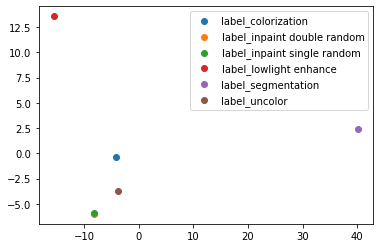

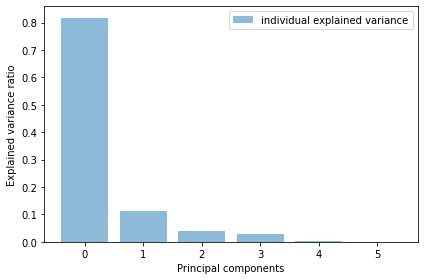

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the shape of the encoder
encoder_shape = holder["label_colorization"][0].shape
print(f'Encoder shape: {encoder_shape}')

# Reshape the encoder data and create a dataset
dataset = np.array([holder[k].reshape(-1) for k in holder.keys()])

# Perform PCA on the dataset
pca = PCA(n_components=6)
pca_result = pca.fit_transform(dataset)

# Plot the PCA result
for i, label in enumerate(holder.keys()):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], label=label)

plt.legend()
plt.show()

# Plot the variance that each PC captures
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(6, 4))
plt.bar(range(6), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [45]:
stacked_decoder_data = [ele.reshape(4096) for ele in decoder_data_list]
stacked_encoder_data = [ele.reshape(24576) for ele in encoder_data_list]

In [57]:
import pickle
import torch
import numpy as np

holder = {}

for i in set(labels_list):
    keep_indices = np.array(labels_list) == i
    kept_decoder = torch.tensor(decoder_data_list)[keep_indices]
    kept_encoder = torch.tensor(encoder_data_list)[keep_indices]

    encoder_mean = kept_encoder.mean(dim=0)
    decoder_mean = kept_decoder.mean(dim=0)

    # Calculate distances from the mean
    distances_encoder = torch.norm(kept_encoder - encoder_mean, dim=2)
    distances_decoder = torch.norm(kept_decoder - decoder_mean, dim=2)

    closest_full_encoder_idx = torch.argmin(distances_encoder.norm(dim=1))
    closest_full_decoder_idx = torch.argmin(distances_decoder.norm(dim=1))
    closest_full_encoder = kept_encoder[closest_full_encoder_idx]
    closest_full_decoder = kept_decoder[closest_full_decoder_idx]

    closest_piecewise_encoder = torch.zeros_like(kept_encoder[0])
    for layer in range(kept_encoder.shape[1]):
        # Calculate the mean for the current layer
        layer_mean = kept_encoder[:, layer, :].mean(dim=0)

        # Calculate distances from the layer mean
        distances = torch.norm(kept_encoder[:, layer, :] - layer_mean, dim=1)

        # Find the index of the minimum distance
        closest_idx = torch.argmin(distances)

        # Store the closest vector for this layer
        closest_piecewise_encoder[layer] = kept_encoder[closest_idx, layer]

    closest_piecewise_decoder = torch.zeros_like(kept_decoder[0])
    for layer in range(kept_decoder.shape[1]):

        # Calculate the mean for the current layer
        layer_mean = kept_decoder[:, layer, :].mean(dim=0)

        # Calculate distances from the layer mean
        distances = torch.norm(kept_decoder[:, layer, :] - layer_mean, dim=1)

        # Find the index of the minimum distance
        closest_idx = torch.argmin(distances)

        # Store the closest vector for this layer
        closest_piecewise_decoder[layer] = kept_decoder[closest_idx, layer]

    curr = {
            "mean": [{"encoder": encoder_mean, "decoder": decoder_mean}],
            "median": [{"encoder": kept_encoder.median(dim=0), "decoder": kept_decoder.median(dim=0)}],
            "closest_to_mean": [{"encoder": closest_full_encoder, "decoder": closest_full_decoder}],
            "piecewise_closest_to_mean": [{"encoder": closest_piecewise_encoder, "decoder": closest_piecewise_decoder}]
        }

    holder[i] = curr


In [66]:
import pickle 

with open("vectors/mean_norm_activations.pkl", "rb") as file:
    filtered = pickle.load(file)
with open("vectors/baseline.pkl", "rb") as file:
    unfiltered = pickle.load(file)

In [67]:
for i in filtered.keys():
    filtered[i] = filtered[i]["mean"][0]["decoder"]

In [68]:
for i in filtered.keys():
    unfiltered[i] = torch.norm(torch.tensor(unfiltered[i]), dim=-1)
    filtered[i] = torch.norm(torch.tensor(filtered[i]), dim=-1)

/tmp/ipykernel_589876/1479054286.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filtered[i] = torch.norm(torch.tensor(filtered[i]), dim=-1)


In [70]:
avg_tensor = torch.zeros_like(unfiltered[list(unfiltered.keys())[0]])
for key in unfiltered.keys():
    avg_tensor += unfiltered[key] + filtered[key]
avg_tensor /= len(unfiltered.keys())*2


In [24]:
for i in filtered.keys():
    if i in ["label_colorization","label_inpaint single random",'label_lowlight enhance', 'label_segmentation']:
        filtered_vector = np.array(filtered[i].reshape(-1))
        unfiltered_vector = np.array(unfiltered[i].reshape(-1))
        similarity = np.dot(filtered_vector, unfiltered_vector) / (np.linalg.norm(filtered_vector) * np.linalg.norm(unfiltered_vector))
        print(i, similarity)


label_colorization 0.9365922
label_inpaint single random 0.8706658
label_lowlight enhance 0.93362224
label_segmentation 0.90853167


In [26]:
file_path = "vectors/baseline.pkl"
with open(file_path, "wb") as file:
    pickle.dump(avg_tensors, file)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch  # Ensure torch is imported

focus_labels = ['label_segmentation', 'label_lowlight enhance','label_colorization']

focus_indices = [i for i, label in enumerate(labels) if label in focus_labels]
focus_latents = [all_latents[i] for i in focus_indices]
pca_focus_result = pca.fit_transform(np.array(focus_latents))

categories = list(set(focus_labels))
for category in categories:
    # Select rows that belong to the current category
    indices = np.array(labels) == category  # Ensure labels_list is in a compatible format
    plt.scatter(pca_focus_result[indices, 0], pca_focus_result[indices, 1], s=50, alpha=0.7, label=category)  # Adjusted marker size

# Add plot title, labels, and legend
plt.title('PCA Projection Colored by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()

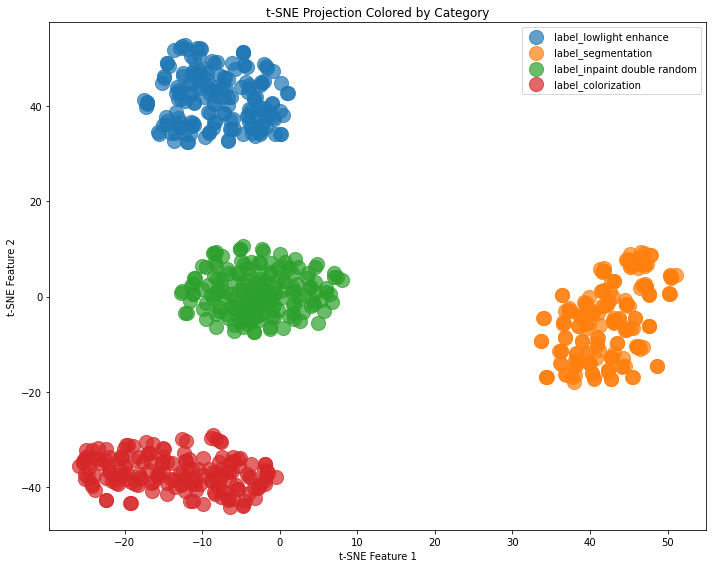

In [56]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 8))
categories = list(set(labels_list))
for category in categories:
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 200, alpha=0.7, label=category)

# Add plot title, labels, and legend
plt.title('t-SNE Projection Colored by Category')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()  # Places the legend to the right of the plot

# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()